In [1]:
import math
import time
import random
import pandas as pd

In [2]:
df = pd.read_csv("pcb_hole_coordinates.txt")
df_lsts = []
df_17 = df[df["radius"] == "1.7"].reset_index(drop=True).reset_index()
df_lsts.append(df_17)
df_15 = df[df["radius"] == "1.5"].reset_index(drop=True).reset_index()
df_lsts.append(df_15)
df_14 = df[df["radius"] == "1.4"].reset_index(drop=True).reset_index()
df_lsts.append(df_14)
df_13 = df[df["radius"] == "1.3"].reset_index(drop=True).reset_index()
df_lsts.append(df_13)
df_11 = df[df["radius"] == "1.118"].reset_index(drop=True).reset_index()
df_lsts.append(df_11)
df_10 = df[df["radius"] == "1"].reset_index(drop=True).reset_index()
df_lsts.append(df_10)
df_08a = df[df["radius"] == "0.8"].reset_index(drop=True).reset_index()
df_lsts.append(df_08a)
df_08b = df[df["radius"] == "0.8b"].reset_index(drop=True).reset_index()
df_lsts.append(df_08b)
df_075 = df[df["radius"] == "0.75"].reset_index(drop=True).reset_index()
df_lsts.append(df_075)
df_07 = df[df["radius"] == "0.7"].reset_index(drop=True).reset_index()
df_lsts.append(df_07)
df_04 = df[df["radius"] == "0.4"].reset_index(drop=True).reset_index()
df_lsts.append(df_04)

In [3]:
def calcDistance(holes): # There is a need for this function in each algorithm, this basically calculates distance between consecutive points
    total_sum = 0
    for i in range(len(holes) - 1):
        holeA = holes[i]
        holeB = holes[i + 1]
        d = math.sqrt(math.pow(holeB[1] - holeA[1], 2) + math.pow(holeB[2] - holeA[2], 2))
        total_sum += d
    holeA = holes[0]
    holeB = holes[-1]
    d = math.sqrt(math.pow(holeB[1] - holeA[1], 2) + math.pow(holeB[2] - holeA[2], 2))
    total_sum += d
    return total_sum


In [4]:
def select_population(holes, size):
    population = []
    for i in range(size):
        # Create a copy to avoid modifying the original holes list
        c = holes.copy()
        # Randomly shuffle the order of elements (possible solutions)
        random.shuffle(c)
        # Calculate the fitness (distance) of the shuffled arrangement
        distance = calcDistance(c)
        # Add the [distance, solution] pair to the population
        population.append([distance, c])
    # Return the entire population and the best individual (lowest distance)
    return population, sorted(population)[0]


def crossover(parent1, parent2):
    # Randomly select two crossover points within the chromosome length
    start, end = sorted(random.sample(range(len(parent1)), 2))
    # Create an empty child chromosome
    child = [None] * len(parent1)
    # Copy a section of parent1's genes into the child
    child[start:end] = parent1[start:end]
    current_pos = end
    # Fill the remaining part of the child with unique genes from parent2
    for gene in parent2:
        if gene not in child:
            child[current_pos] = gene
            current_pos += 1
            # Wrap around if the end of the chromosome is reached
            if current_pos >= len(child):
                current_pos = 0
    return child


def genetic_algorithm(population, lenholes, tournament_size, mutation_rate, crossover_rate, target):
    start = time.time() # Record start time for performance tracking
    gen_number = 0
    for i in range(200): # Run for a maximum of 200 generations
        new_population = []

        # Elitism
        new_population.append(sorted(population)[0]) # Add the fittest individual
        new_population.append(sorted(population)[1]) # Add the second-fittest individual

        for i in range(int((len(population) - 2) / 2)):
            # Selection (tournament selection)
            if random.random() < crossover_rate:
                # Select parents using a tournament (randomly choose individuals and keep the best)
                parent1 = sorted(random.choices(population, k=tournament_size))[0][1]
                parent2 = sorted(random.choices(population, k=tournament_size))[0][1]
                # Crossover (create offspring)
                child1 = crossover(parent1, parent2)
                child2 = crossover(parent2, parent1)
            else:
                # If crossover is not selected, randomly choose parents for reproduction
                child1 = random.choices(population)[0][1]
                child2 = random.choices(population)[0][1]

            # Mutation (introduce random changes)
            if random.random() < mutation_rate:
                # Swap two random genes in child1
                point1, point2 = random.sample(range(len(child1)), 2)
                child1[point1], child1[point2] = child1[point2], child1[point1]
                point1, point2 = random.sample(range(len(child2)), 2)
                child2[point1], child2[point2] = child2[point2], child2[point1]

            new_population.append([calcDistance(child1), child1])
            new_population.append([calcDistance(child2), child2])

        population = new_population
        gen_number += 1

        if gen_number % 10 == 0:
            print(f"Generation {gen_number}: {sorted(population)[0][0]}")

        if sorted(population)[0][0] < target:
            break
    finish = time.time()
    time_passed = finish - start
    return sorted(population)[0], gen_number, time_passed

In [5]:
def simulated_annealing(holes, temp, cooling_rate):
    start = time.time()  # Record start time for performance tracking

    def swap_two_holes(route):
        """Swaps two randomly chosen elements in the route."""
        new_route = route.copy()  # Create a copy to avoid modifying the original route
        i, j = random.sample(range(len(route)), 2)  # Randomly select two indices
        new_route[i], new_route[j] = new_route[j], new_route[i]  # Swap elements at those indices
        return new_route

    current_solution = holes.copy()  # Initialize current solution as a copy of holes
    best_solution = holes.copy()  # Initialize best solution as a copy of holes
    current_distance = calcDistance(current_solution)  # Calculate initial distance
    best_distance = current_distance  # Initialize best distance as initial distance

    while temp > 1:  # Loop until temperature cools down significantly
        new_solution = swap_two_holes(current_solution)  # Create a new solution by swapping elements
        new_distance = calcDistance(new_solution)  # Calculate the distance of the new solution

        # Accept the new solution if it's better or probabilistically based on temperature
        delta = current_distance - new_distance  # Calculate the difference in distance (improvement)
        sigmoid = math.exp(-max(min(delta / temp, 10), -10))
        if delta < 0 or random.random() < sigmoid:  # Metropolis criterion
            current_solution = new_solution  # Update current solution if accepted
            current_distance = new_distance  # Update current distance

            # Update best solution if the new solution is better
            if new_distance < best_distance:
                best_solution = new_solution
                best_distance = new_distance

        temp *= cooling_rate  # Decrease the temperature for the next iteration

    finish = time.time()  # Record end time
    time_passed = finish - start  # Calculate total execution time

    return best_solution, best_distance, time_passed


In [6]:
class Particle:
    def __init__(self, holes):
        self.position = random.sample(holes, len(holes)) # Random initial position
        self.velocity = [0] * len(self.position) # Zero initial velocity for each dimension
        self.best_position = self.position # Copy of initial position as best so far
        self.best_distance = calcDistance(self.position) # Distance of the initial position

    def update_velocity(self, global_best_position, inertia, cognitive, social):
        """
        Updates the particle's velocity based on three components:
          - inertia: tendency to continue in the current direction
          - cognitive component: based on the particle's own best experience
          - social component: influenced by the swarm's global best position
        """
        new_velocity = []
        for i in range(len(self.position)):
            r1 = random.random()
            r2 = random.random()
            # Cognitive component: attracts particle towards its own best position
            cognitive_velocity = cognitive * r1 * (self.best_position[i][1] - self.position[i][1])
            # Social component: attracts particle towards the swarm's global best position
            social_velocity = social * r2 * (global_best_position[i][1] - self.position[i][1])
            # Update velocity using inertia, cognitive, and social components
            new_velocity.append(inertia * self.velocity[i] + cognitive_velocity + social_velocity)
        self.velocity = new_velocity

    def update_position(self):
        """
        Updates the particle's position based on its current velocity.
        Uses a sigmoid function to constrain the random number between -1 and 1
        for applying the velocity to the position.
        """
        new_position = self.position.copy()
        for i in range(len(new_position)):
            sigmoid = 1 / (1 + math.exp(-max(min(self.velocity[i], 10), -10)))  # constrain the input to exp()
            if random.random() < sigmoid:
                j = random.randint(0, len(new_position) - 1)
                new_position[i], new_position[j] = new_position[j], new_position[i]
        self.position = new_position
        new_distance = calcDistance(new_position)
        if new_distance < self.best_distance:
            self.best_position = new_position
            self.best_distance = new_distance # Update best distance if improved


def particle_swarm_optimization(holes, pop_size, inertia, cognitive, social, max_iter):
    """
    Implements the Particle Swarm Optimization (PSO) algorithm.

    Args:
        holes: The set of possible solutions (e.g., list of cities).
        pop_size: The number of particles in the swarm.
        inertia: Weight given to the particle's previous velocity.
        cognitive: Weight given to the particle's own best experience.
        social: Weight given to the swarm's global best position.
        max_iter: The maximum number of iterations.

    Returns:
        The best solution found, its distance, and the execution time.
    """
    start = time.time()
    swarm = [Particle(holes) for _ in range(pop_size)]
    global_best_position = min(swarm, key=lambda p: p.best_distance).best_position
    global_best_distance = calcDistance(global_best_position)

    for _ in range(max_iter):
        for particle in swarm:
            particle.update_velocity(global_best_position, inertia, cognitive, social)
            particle.update_position()
            if calcDistance(particle.best_position) < global_best_distance:
                global_best_position = particle.best_position
                global_best_distance = calcDistance(global_best_position)
    finish = time.time()
    time_passed = finish - start
    return global_best_position, global_best_distance, time_passed


In [7]:
def main(df):
    holes = df.values.tolist()

    # Genetic Algorithm parameters
    POPULATION_SIZE = 200
    TOURNAMENT_SELECTION_SIZE = 4
    MUTATION_RATE = 0.1
    CROSSOVER_RATE = 0.9
    TARGET = 450.0

    # Simulated Annealing parameters
    INITIAL_TEMP = 10000
    COOLING_RATE = 0.995

    # Particle Swarm Optimization parameters
    SWARM_SIZE = 30
    INERTIA = 0.5
    COGNITIVE = 1.5
    SOCIAL = 2.0
    MAX_ITER = 100

    # Run Genetic Algorithm
    print("Running Genetic Algorithm...")
    initial_population, _ = select_population(holes, POPULATION_SIZE)
    best_genetic, _, time_passed1 = genetic_algorithm(initial_population, len(holes), TOURNAMENT_SELECTION_SIZE,
                                                     MUTATION_RATE,
                                                     CROSSOVER_RATE, TARGET)
    print("Genetic Algorithm Best Distance:", best_genetic[0])
    print("Time:", time_passed1)

    # Run Simulated Annealing
    print("\nRunning Simulated Annealing...")
    best_sa, _, time_passed2 = simulated_annealing(holes, INITIAL_TEMP, COOLING_RATE)
    sa = [best_sa, _, time_passed2]
    print("Simulated Annealing Best Distance:", calcDistance(best_sa))
    print("Time:", time_passed2)

    # Run Particle Swarm Optimization
    print("\nRunning Particle Swarm Optimization...")
    best_pso, _, time_passed3 = particle_swarm_optimization(holes, SWARM_SIZE, INERTIA, COGNITIVE, SOCIAL, MAX_ITER)
    ps = [best_pso, _, time_passed3]
    print("Particle Swarm Optimization Best Distance:", calcDistance(best_pso))
    print("Time:", time_passed3)

    return best_genetic, sa, ps, time_passed1

Investing Results and Comparing Them

In [8]:
results = []

In [9]:
genetic, sa, ps, t1 = main(df_lsts[0])
results.append([4, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Genetic Algorithm Best Distance: 113.80584360149872
Time: 0.0010039806365966797

Running Simulated Annealing...
Simulated Annealing Best Distance: 113.80584360149872
Time: 0.007994413375854492

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 113.80584360149872
Time: 0.0242307186126709


In [10]:
genetic, sa, ps, t1 = main(df_lsts[2])
results.append([16, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Generation 10: 968.1426455865568
Generation 20: 858.1591831996229
Generation 30: 828.7594549382517
Generation 40: 828.7594549382517
Generation 50: 828.7594549382517
Generation 60: 828.7594549382517
Generation 70: 828.7594549382517
Generation 80: 828.7594549382517
Generation 90: 828.7594549382517
Generation 100: 828.7594549382517
Generation 110: 828.7594549382517
Generation 120: 828.7594549382517
Generation 130: 828.7594549382517
Generation 140: 828.7594549382517
Generation 150: 828.7594549382517
Generation 160: 828.7594549382517
Generation 170: 828.7594549382517
Generation 180: 828.7594549382517
Generation 190: 828.7594549382517
Generation 200: 828.7594549382517
Genetic Algorithm Best Distance: 828.7594549382517
Time: 0.5165696144104004

Running Simulated Annealing...
Simulated Annealing Best Distance: 1340.530170206977
Time: 0.015102148056030273

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 1202.5021949063253
Time: 0.08

In [11]:
genetic, sa, ps, t1 = main(df_lsts[3])
results.append([29, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Generation 10: 4048.5491879016254
Generation 20: 3251.7093708039947
Generation 30: 2960.650990175148
Generation 40: 2807.713794924252
Generation 50: 2651.9485971808945
Generation 60: 2531.9485971808945
Generation 70: 2473.9485971808945
Generation 80: 2413.9485971808945
Generation 90: 2413.9485971808945
Generation 100: 2413.8825036617845
Generation 110: 2295.9485971808945
Generation 120: 2291.9397280885005
Generation 130: 2098.568913784746
Generation 140: 2061.7740668357515
Generation 150: 2061.7740668357515
Generation 160: 1963.0011185668332
Generation 170: 1963.0011185668332
Generation 180: 1963.0011185668332
Generation 190: 1963.0011185668332
Generation 200: 1963.0011185668332
Genetic Algorithm Best Distance: 1963.0011185668332
Time: 0.8738443851470947

Running Simulated Annealing...
Simulated Annealing Best Distance: 2462.5556722118417
Time: 0.023973941802978516

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 6562.45517

In [12]:
genetic, sa, ps, t1 = main(df_lsts[4])
results.append([8, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Genetic Algorithm Best Distance: 206.0
Time: 0.0018351078033447266

Running Simulated Annealing...
Simulated Annealing Best Distance: 176.0
Time: 0.011062860488891602

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 176.0
Time: 0.043554067611694336


In [13]:
genetic, sa, ps, t1 = main(df_lsts[5])
results.append([48, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Generation 10: 5700.866079295134
Generation 20: 4616.354991240143
Generation 30: 4162.0450539802
Generation 40: 3607.8098583622523
Generation 50: 3311.6232403505146
Generation 60: 2977.846571092836
Generation 70: 2731.2628916792564
Generation 80: 2671.6049554728684
Generation 90: 2535.443608371762
Generation 100: 2473.513910989604
Generation 110: 2431.53374900106
Generation 120: 2404.7491488997102
Generation 130: 2404.7491488997102
Generation 140: 2338.7273866255305
Generation 150: 2258.3437699469296
Generation 160: 2258.343769946929
Generation 170: 2221.8196883888527
Generation 180: 2214.7148458711736
Generation 190: 2185.711508876843
Generation 200: 2182.36984830761
Genetic Algorithm Best Distance: 2182.36984830761
Time: 1.6115615367889404

Running Simulated Annealing...
Simulated Annealing Best Distance: 2712.752168971193
Time: 0.03794074058532715

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 7354.12530487582
Time: 0.

In [14]:
genetic, sa, ps, t1 = main(df_lsts[6])
results.append([76, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Generation 10: 10510.181901547978
Generation 20: 8855.028175027164
Generation 30: 7943.782859119819
Generation 40: 7640.664870488417
Generation 50: 6881.067053912058
Generation 60: 6315.341513128562
Generation 70: 5606.881795660016
Generation 80: 5235.030571293579
Generation 90: 5235.030571293579
Generation 100: 5102.334295234798
Generation 110: 4883.241703688727
Generation 120: 4843.206924961646
Generation 130: 4691.934777935335
Generation 140: 4691.934777935335
Generation 150: 4502.563380685887
Generation 160: 4403.056615049483
Generation 170: 4305.691075293086
Generation 180: 4305.691075293086
Generation 190: 4305.691075293086
Generation 200: 4266.882028243071
Genetic Algorithm Best Distance: 4266.882028243071
Time: 2.96994686126709

Running Simulated Annealing...
Simulated Annealing Best Distance: 4346.774619047947
Time: 0.06537365913391113

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 13786.251165750678
Time: 0.3834

In [15]:
genetic, sa, ps, t1 = main(df_lsts[7])
results.append([11, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Generation 10: 1422.0313195715805
Generation 20: 1416.034152368577
Generation 30: 1416.034152368577
Generation 40: 1416.034152368577
Generation 50: 1416.034152368577
Generation 60: 1416.034152368577
Generation 70: 1416.034152368577
Generation 80: 1416.034152368577
Generation 90: 1416.034152368577
Generation 100: 1416.034152368577
Generation 110: 1416.034152368577
Generation 120: 1416.034152368577
Generation 130: 1416.034152368577
Generation 140: 1416.034152368577
Generation 150: 1416.034152368577
Generation 160: 1416.034152368577
Generation 170: 1416.034152368577
Generation 180: 1416.034152368577
Generation 190: 1416.034152368577
Generation 200: 1416.034152368577
Genetic Algorithm Best Distance: 1416.034152368577
Time: 0.39060497283935547

Running Simulated Annealing...
Simulated Annealing Best Distance: 1836.4711723264318
Time: 0.012996435165405273

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 1709.2912695549012
Time: 0

In [16]:
genetic, sa, ps, t1 = main(df_lsts[8])
results.append([15, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Generation 10: 496.05633243417185
Genetic Algorithm Best Distance: 439.71050774767156
Time: 0.04671931266784668

Running Simulated Annealing...
Simulated Annealing Best Distance: 434.9189777325438
Time: 0.016066551208496094

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 644.8427691955843
Time: 0.07813668251037598


In [17]:
genetic, sa, ps, t1 = main(df_lsts[9])
results.append([16, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Generation 10: 798.1459794100712
Generation 20: 735.0208979004473
Generation 30: 716.3930584333598
Generation 40: 692.1601174256044
Generation 50: 685.8307340059137
Generation 60: 656.0
Generation 70: 656.0
Generation 80: 656.0
Generation 90: 656.0
Generation 100: 656.0
Generation 110: 656.0
Generation 120: 656.0
Generation 130: 656.0
Generation 140: 656.0
Generation 150: 656.0
Generation 160: 656.0
Generation 170: 656.0
Generation 180: 656.0
Generation 190: 656.0
Generation 200: 656.0
Genetic Algorithm Best Distance: 656.0
Time: 0.5402827262878418

Running Simulated Annealing...
Simulated Annealing Best Distance: 1138.459411141926
Time: 0.01601243019104004

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 1035.068030306683
Time: 0.09074139595031738


In [18]:
genetic, sa, ps, t1 = main(df_lsts[10])
results.append([23, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Generation 10: 1667.9507898112633
Generation 20: 1444.886295680924
Generation 30: 1228.8968114800127
Generation 40: 1151.4558905048261
Generation 50: 1121.178962376897
Generation 60: 1102.5505430567937
Generation 70: 1078.6413927778826
Generation 80: 1078.6413927778826
Generation 90: 1073.113698596161
Generation 100: 1073.113698596161
Generation 110: 1073.113698596161
Generation 120: 1069.9450353608838
Generation 130: 1069.10542406283
Generation 140: 1069.0155310951109
Generation 150: 1069.0155310951109
Generation 160: 1069.0155310951106
Generation 170: 1069.0155310951106
Generation 180: 1069.0155310951106
Generation 190: 1069.0155310951106
Generation 200: 1069.0155310951106
Genetic Algorithm Best Distance: 1069.0155310951106
Time: 0.7354786396026611

Running Simulated Annealing...
Simulated Annealing Best Distance: 1387.3745498625758
Time: 0.021611690521240234

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 2278.844157497

In [19]:
results

[[4,
  [113.80584360149872, 0.0010039806365966797],
  [113.80584360149872, 0.007994413375854492],
  [113.80584360149872, 0.0242307186126709]],
 [16,
  [828.7594549382517, 0.5165696144104004],
  [1340.530170206977, 0.015102148056030273],
  [1202.5021949063253, 0.08875036239624023]],
 [29,
  [1963.0011185668332, 0.8738443851470947],
  [2462.5556722118417, 0.023973941802978516],
  [6562.455177051327, 0.14940428733825684]],
 [8,
  [206.0, 0.0018351078033447266],
  [176.0, 0.011062860488891602],
  [176.0, 0.043554067611694336]],
 [48,
  [2182.36984830761, 1.6115615367889404],
  [2712.752168971193, 0.03794074058532715],
  [7354.12530487582, 0.24862432479858398]],
 [76,
  [4266.882028243071, 2.96994686126709],
  [4346.774619047947, 0.06537365913391113],
  [13786.251165750678, 0.3834517002105713]],
 [11,
  [1416.034152368577, 0.39060497283935547],
  [1836.4711723264318, 0.012996435165405273],
  [1709.2912695549012, 0.05890035629272461]],
 [15,
  [439.71050774767156, 0.04671931266784668],
  [43

In [20]:
import matplotlib.pyplot as plt

def plot_solution(cities, solution):
    # Extract coordinates
    x = [city[1] for city in solution]
    y = [city[2] for city in solution]

    # Plot points
    plt.scatter(x, y, color='blue')

    # Plot path
    for i in range(len(solution) - 1):
        plt.plot([solution[i][1], solution[i + 1][1]], [solution[i][2], solution[i + 1][2]], color='red')
    plt.plot([solution[-1][1], solution[0][1]], [solution[-1][2], solution[0][2]], color='red')  # Closing the loop

    # Set labels
    plt.title('PCB Drilling Path Optimization')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

In [23]:
for item in results:
    for i in range(1,4):
        item[i][0] = int(item[i][0])
results = pd.DataFrame(results, columns=["holes", "Genetic", "SA", "PS"])

In [24]:
results

,holes,Genetic,SA,PS
0,4,"[113, 0.0010039806365966797]","[113, 0.007994413375854492]","[113, 0.0242307186126709]"
1,16,"[828, 0.5165696144104004]","[1340, 0.015102148056030273]","[1202, 0.08875036239624023]"
2,29,"[1963, 0.8738443851470947]","[2462, 0.023973941802978516]","[6562, 0.14940428733825684]"
3,8,"[206, 0.0018351078033447266]","[176, 0.011062860488891602]","[176, 0.043554067611694336]"
4,48,"[2182, 1.6115615367889404]","[2712, 0.03794074058532715]","[7354, 0.24862432479858398]"
5,76,"[4266, 2.96994686126709]","[4346, 0.06537365913391113]","[13786, 0.3834517002105713]"
6,11,"[1416, 0.39060497283935547]","[1836, 0.012996435165405273]","[1709, 0.05890035629272461]"
7,15,"[439, 0.04671931266784668]","[434, 0.016066551208496094]","[644, 0.07813668251037598]"
8,16,"[656, 0.5402827262878418]","[1138, 0.01601243019104004]","[1035, 0.09074139595031738]"
9,23,"[1069, 0.7354786396026611]","[1387, 0.021611690521240234]","[2278, 0.1325850486755371]"


Running Genetic Algorithm...
Generation 10: 1080.8895512013864
Generation 20: 850.9741486657106
Generation 30: 850.9741486657103
Generation 40: 837.6339844788823
Generation 50: 837.6339844788823
Generation 60: 828.7594549382517
Generation 70: 828.7594549382517
Generation 80: 828.7594549382517
Generation 90: 828.7594549382517
Generation 100: 828.7594549382517
Generation 110: 828.7594549382517
Generation 120: 828.7594549382517
Generation 130: 828.7594549382517
Generation 140: 828.7594549382517
Generation 150: 828.7594549382517
Generation 160: 828.7594549382517
Generation 170: 828.7594549382517
Generation 180: 828.7594549382517
Generation 190: 828.7594549382517
Generation 200: 828.7594549382517
Genetic Algorithm Best Distance: 828.7594549382517
Time: 0.5503420829772949

Running Simulated Annealing...
Simulated Annealing Best Distance: 1371.2515067133918
Time: 0.024932861328125

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 1334.2472410134976
Time: 0.290

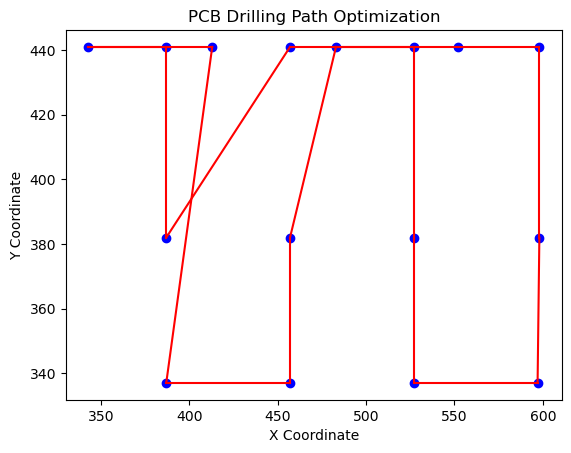

In [29]:
genetic, sa, ps, t1 = main(df_lsts[2])
plot_solution(df_lsts[2], genetic[1])

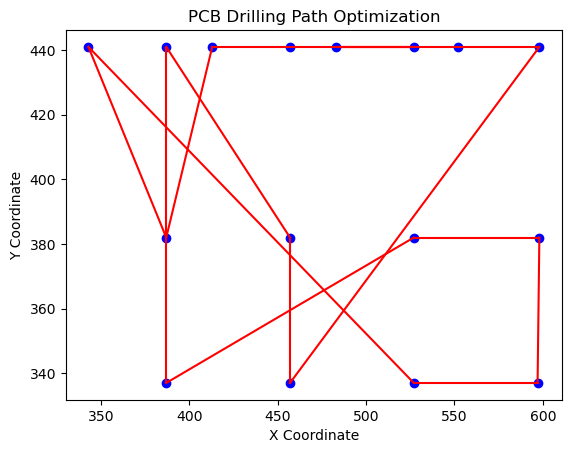

In [30]:
plot_solution(df_lsts[2], sa[0])

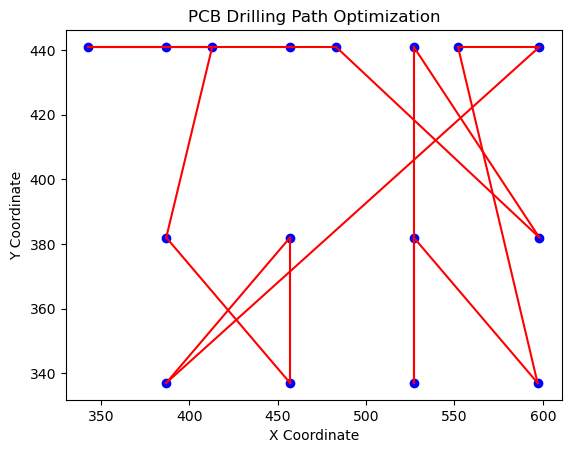

In [31]:
plot_solution(df_lsts[2], ps[0])

Running Genetic Algorithm...
Generation 10: 5047.368425744824
Generation 20: 3839.4403545464083
Generation 30: 3219.8780419062296
Generation 40: 3164.6240808456864
Generation 50: 2746.0025030077345
Generation 60: 2746.0025030077345
Generation 70: 2725.3863194223004
Generation 80: 2654.950577998985
Generation 90: 2563.0792349819767
Generation 100: 2503.0792349819767
Generation 110: 2473.8882097347605
Generation 120: 2348.1849516874768
Generation 130: 2348.1849516874768
Generation 140: 2332.7796471581396
Generation 150: 2288.1849516874768
Generation 160: 2212.7796471581396
Generation 170: 2114.0066988892213
Generation 180: 2114.0066988892213
Generation 190: 2087.0099876592267
Generation 200: 2087.0099876592267
Genetic Algorithm Best Distance: 2087.0099876592267
Time: 0.8839931488037109

Running Simulated Annealing...
Simulated Annealing Best Distance: 2462.5556722118417
Time: 0.025739192962646484

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 7425.7946

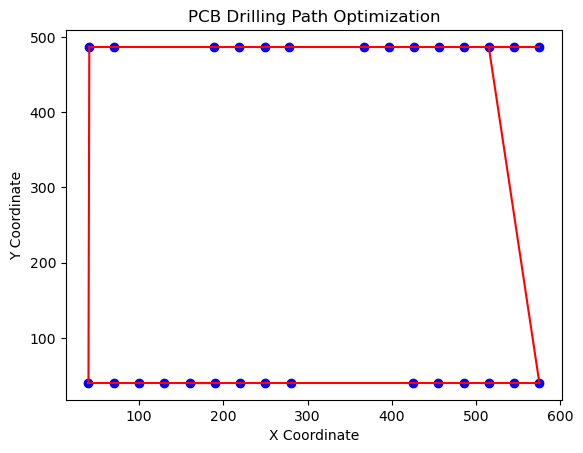

In [32]:
genetic, sa, ps, t1 = main(df_lsts[3])
plot_solution(df_lsts[3], genetic[1])

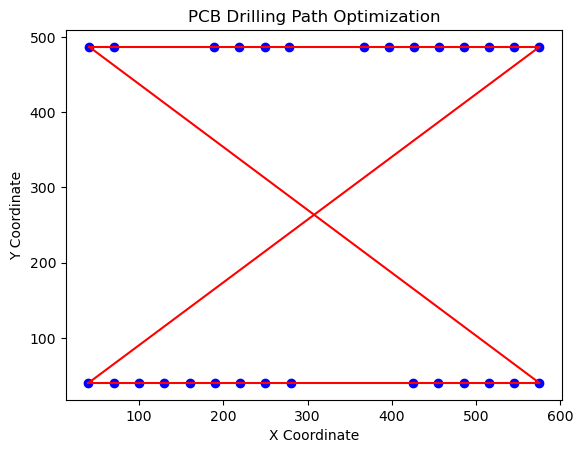

In [33]:
plot_solution(df_lsts[3], sa[0])

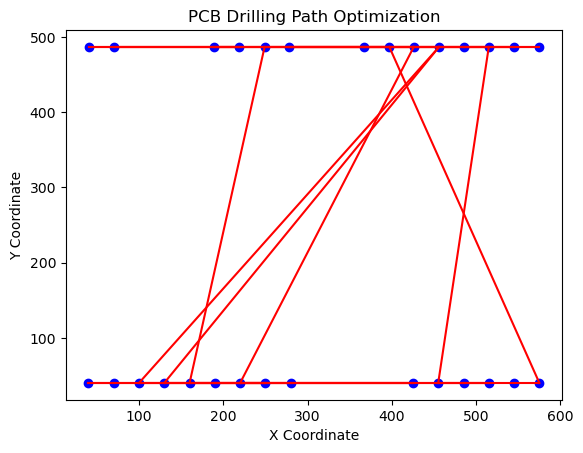

In [34]:
plot_solution(df_lsts[3], ps[0])

Running Genetic Algorithm...
Genetic Algorithm Best Distance: 204.0
Time: 0.0020606517791748047

Running Simulated Annealing...
Simulated Annealing Best Distance: 193.48655719667784
Time: 0.01210331916809082

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 176.0
Time: 0.049614667892456055


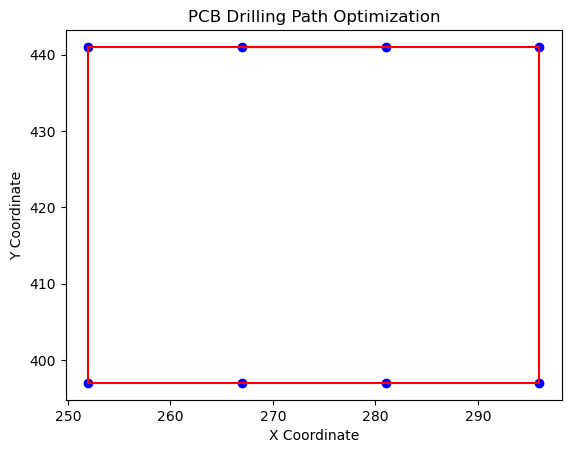

In [36]:
genetic, sa, ps, t1 = main(df_lsts[4])
plot_solution(df_lsts[4], genetic[1])

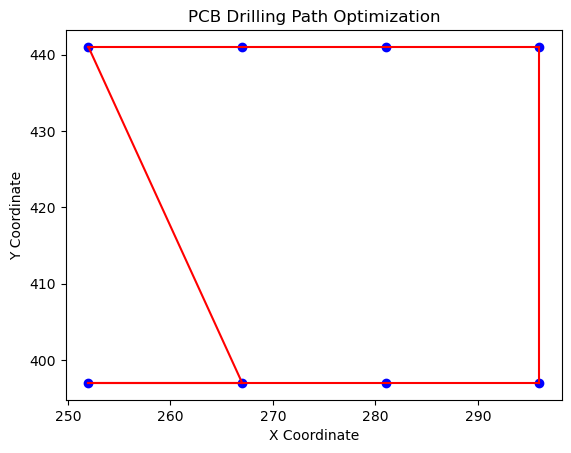

In [37]:
plot_solution(df_lsts[4], sa[0])

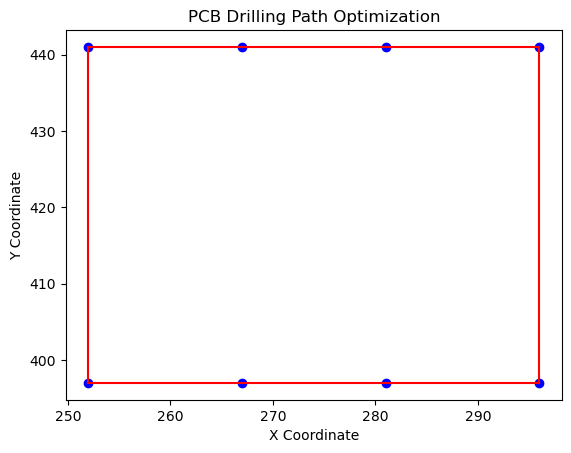

In [38]:
plot_solution(df_lsts[4], ps[0])

Running Genetic Algorithm...
Generation 10: 5834.874198279738
Generation 20: 4509.426093435003
Generation 30: 3867.5456330359616
Generation 40: 3166.237162498894
Generation 50: 3073.6691544582422
Generation 60: 2986.6605496718366
Generation 70: 2896.599593690708
Generation 80: 2612.552559361827
Generation 90: 2523.900048943345
Generation 100: 2503.083044070172
Generation 110: 2476.348065749283
Generation 120: 2406.720655832958
Generation 130: 2378.7206558329585
Generation 140: 2348.0702032829777
Generation 150: 2020.9627137828047
Generation 160: 2020.9627137828047
Generation 170: 1989.4331696101062
Generation 180: 1956.5078073940451
Generation 190: 1956.5078073940451
Generation 200: 1946.3306130503704
Genetic Algorithm Best Distance: 1946.3306130503704
Time: 1.747589349746704

Running Simulated Annealing...
Simulated Annealing Best Distance: 2712.752168971193
Time: 0.03999638557434082

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 7485.609060063224
T

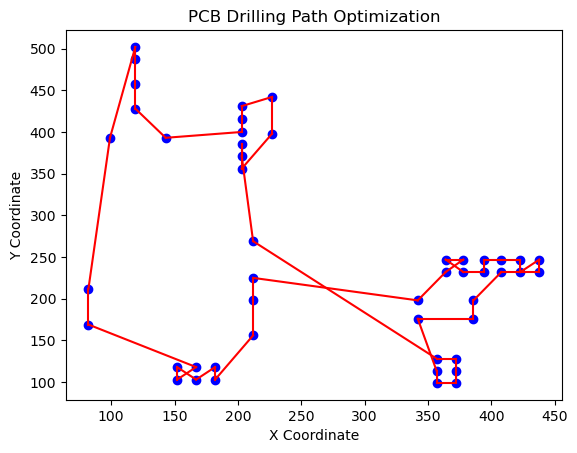

In [39]:
genetic, sa, ps, t1 = main(df_lsts[5])
plot_solution(df_lsts[5], genetic[1])

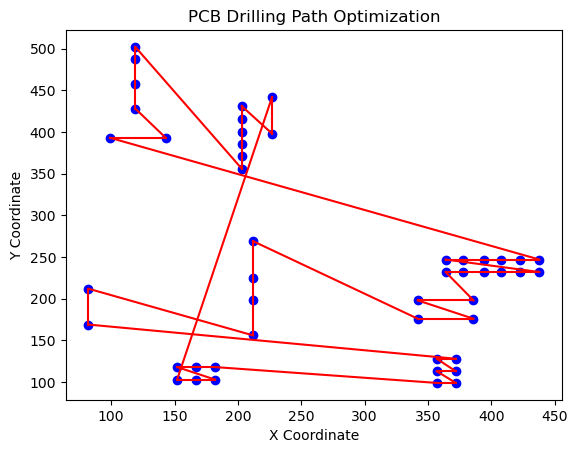

In [40]:
plot_solution(df_lsts[5], sa[0])

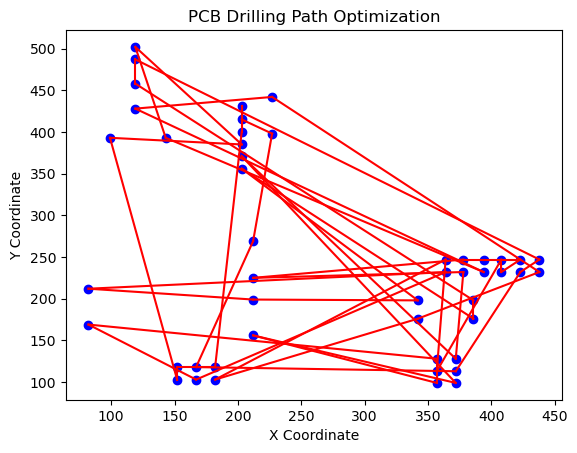

In [41]:
plot_solution(df_lsts[5], ps[0])